# 2.4. Pretty plots for Section 2 (with full archive)

Make the plots for the paper.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from knnxkde import KNNxKDE
from utils import normalization, renormalization
from utils import convolution_TLG2020_fix_incl

## Prepare dataset

In [2]:
original_df = pd.read_csv('data/exoplanets2023.csv')

my_df = original_df.copy()
for n in range(len(my_df)):
    if my_df.loc[n, 'pl_bmassprov'] == 'Msini':
        my_df.loc[n, 'pl_bmassj'] = np.nan

In [3]:
TLG2020_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_eqt',
    'st_mass',
    'sy_pnum',
]

In [4]:
X = np.array(my_df[TLG2020_FEATURES])
X[:, [0, 1, 2, 3, 4]] = np.log(X[:, [0, 1, 2, 3, 4]])
X_df = pd.DataFrame(X, columns=TLG2020_FEATURES)

## Load previous results (Transit scenario)

In [5]:
DICT_OBSERVED_MASS_NAME_ID = dict()  # store the name and row number of planets with observed mass
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASSES = len(DICT_OBSERVED_MASS_NAME_ID)

In [6]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/transit_case_masses.pkl', 'rb') as f:
    imputed_masses = pickle.load(f)

In [7]:
np_masses = np.zeros((2, NB_OBSERVED_MASSES))
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    np_masses[0, i] = imputed_masses['knnxkde'][cur_name]

In [8]:
np_eps = np.zeros(NB_OBSERVED_MASSES)
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    true_mass = my_df.iloc[cur_idx]['pl_bmassj']
    np_eps[i] = np.log(true_mass) - np.log(imputed_masses['knnxkde'][cur_name])
    np_masses[1, i] = true_mass

In [9]:
print(np.sqrt(np.mean(np_eps ** 2.0)))

1.5101502622333234


### My ploting functions (Transit scenario)

In [31]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

def generate_planet_bio(n):
    cur_data = my_df.iloc[n]
    pl_rade = cur_data['pl_radj'] * RJ  # radius in Earth radii
    pl_masse = cur_data['pl_bmassj'] * MJ  # mass in Earth masses
    pl_orbper = cur_data['pl_orbper']  # in days
    pl_teq = cur_data['pl_eqt']  # in K
    st_mass = cur_data['st_mass']  # in Solar masses
    pl_pnum = cur_data['sy_pnum']
    my_text = fr'$r_p$ = {pl_rade:.1f} $r_\oplus$' + '\n'
    my_text += fr'$m_p$ = {pl_masse:.1f} $m_\oplus$' + '\n'
    my_text += fr'$P$ = {pl_orbper:.1f} days' + '\n'
    my_text += r'$T_{\rm eq.}$' + f' = {pl_teq:.0f} K' + '\n'
    my_text += fr'$m_\ast$ = {st_mass:.1f} $m_\odot$' + '\n'
    my_text += r'$N_{\rm pl.}$' + f' = {pl_pnum}'
    return my_text

In [70]:
def plot_hist_given_idx_and_ax(my_idx, my_ax, bio_xloc, legend_loc, hide_xtickslabels=False, yticksright=False):
    
    for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
        if i == my_idx:
            save_name = cur_name
            print(f'i = {i} ; Name = {save_name} ; Common idx = {cur_idx}')
            miss_data = np.copy(X)
            miss_data[cur_idx, 1] = np.nan  # Transit case: hide the mass
            norm_miss_data, norm_params = normalization(miss_data)
            m1 = norm_params['min_val'][1]
            m2 = norm_params['max_val'][1]

            knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
            knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=NB_DRAWS)
            knnxkde_renorm_sample = np.exp(knnxkde_samples[(cur_idx, 1)] * (m2 + 1e-6) + m1) * MJ

            true_mass = my_df.iloc[cur_idx]['pl_bmassj'] * MJ
            imputed_mass = np.exp(np.mean(knnxkde_samples[(cur_idx, 1)]) * (m2 + 1e-6) + m1) * MJ
            eps = np.log(true_mass) - np.log(imputed_mass)

            planet_bio = generate_planet_bio(cur_idx)
            title = my_df.iloc[cur_idx]['pl_name']
    
    my_ax.hist(knnxkde_renorm_sample, bins=my_mass_bins, weights=my_weights, color='C3', alpha=0.4)
    my_ax.axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    my_ax.axvline(imputed_mass, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps):.2f}')

    if not yticksright:  # only for the left plots, compare with "assess-damage" distributions
        with open(f'results_and_figures/2_comp_whole_archive/_assessing_damage/transit_mass_{save_name}.pkl', 'rb') as f:
            distrib_bis = pickle.load(f)
        imputed_mass_bis = np.exp(np.mean(np.log(distrib_bis))) * MJ
        eps_bis = np.log(true_mass) - np.log(imputed_mass_bis)
        my_ax.hist(distrib_bis*MJ, bins=my_mass_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
        my_ax.axvline(imputed_mass_bis, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(eps_bis):.2f}')
    
    my_ax.set_xscale('log')
    my_ax.set_ylabel('Prop.')

    if yticksright:
        my_ax.yaxis.tick_right()
        my_ax.yaxis.set_label_position('right')
    
    if hide_xtickslabels:
        my_ax.xaxis.set_ticklabels([])
    
    props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
    my_ax.text(bio_xloc, 0.95, planet_bio, transform=my_ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    my_ax.legend(loc=legend_loc, fontsize=10, title=title, title_fontsize=11, framealpha=0.6)

In [12]:
MY_TAU = 1.0 / 50.0  # for kNNxKDE
MY_NB_NEIGH = 20  # for kNNxKDE
NB_DRAWS = 10000
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights = np.ones(NB_DRAWS) / NB_DRAWS
N, D = X.shape

i = 144 ; Name = HAT-P-57 b ; Common idx = 358
i = 881 ; Name = Kepler-9 c ; Common idx = 4417
i = 713 ; Name = Kepler-30 c ; Common idx = 3460
i = 1211 ; Name = TRAPPIST-1 f ; Common idx = 4966
i = 238 ; Name = HD 109988 b ; Common idx = 507
i = 1222 ; Name = USco CTIO 108 b ; Common idx = 4986


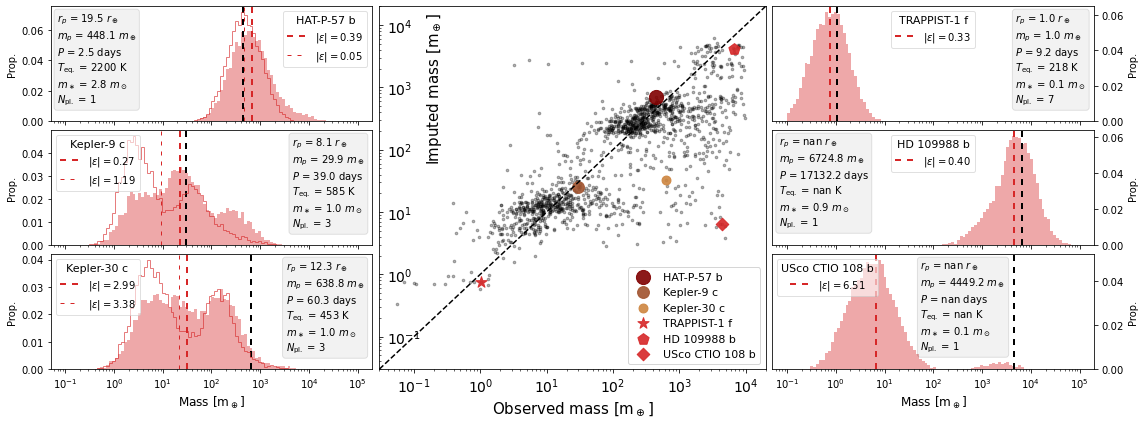

In [15]:
MJ = 317.8  # in Earth masses
MIN_MASS, MAX_MASS = 3e-2, 2e4  # 3e-1, 1.3e4

gs_kw = dict(width_ratios=[5, 6, 5])
fig, ax = plt.subplot_mosaic(
    [['hist_1a', 'main', 'hist_2a'],
     ['hist_1b', 'main', 'hist_2b'],
     ['hist_1c', 'main', 'hist_2c']],
    gridspec_kw=gs_kw, figsize=(16, 6),
)

ax['main'].scatter(np_masses[1]*MJ, np_masses[0]*MJ, c='black', s=7, alpha=0.3)

idx1, idx2, idx3 = 144, 881, 713  # HAT-P-57 b (GOOD), Kepler-9 c (AMBIGUOUS), Kepler-30 c (BAD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
label3 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx3]
ax['main'].scatter(np_masses[1][idx1]*MJ, np_masses[0][idx1]*MJ, c='maroon', s=200, alpha=0.9, label=label1)
ax['main'].scatter(np_masses[1][idx2]*MJ, np_masses[0][idx2]*MJ, c='sienna', s=140, alpha=0.9, label=label2)
ax['main'].scatter(np_masses[1][idx3]*MJ, np_masses[0][idx3]*MJ, c='peru', s=80, alpha=0.9, label=label3)
plot_hist_given_idx_and_ax(my_idx=idx1, my_ax=ax['hist_1a'], bio_xloc=0.02, legend_loc='upper right', hide_xtickslabels=True)
plot_hist_given_idx_and_ax(my_idx=idx2, my_ax=ax['hist_1b'], bio_xloc=0.75, legend_loc='upper left', hide_xtickslabels=True)
plot_hist_given_idx_and_ax(my_idx=idx3, my_ax=ax['hist_1c'], bio_xloc=0.73, legend_loc='upper left')
ax['hist_1c'].set_xlabel('Mass [m$_\oplus$]', size=12)

idx1, idx2, idx3 = 1211, 238, 1222  # TRAPPIST-1 f (NEW GOOD), HD 109988 b (NEW GOOD), USco CTIO 108 b (NEW BAD)
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
label3 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx3]
ax['main'].scatter(np_masses[1][idx1]*MJ, np_masses[0][idx1]*MJ, c='C3', marker='*', s=140, alpha=0.9, label=label1)
ax['main'].scatter(np_masses[1][idx2]*MJ, np_masses[0][idx2]*MJ, c='C3', marker='p', s=140, alpha=0.9, label=label2)
ax['main'].scatter(np_masses[1][idx3]*MJ, np_masses[0][idx3]*MJ, c='C3', marker='D', s=80, alpha=0.9, label=label3)
plot_hist_given_idx_and_ax(my_idx=idx1, my_ax=ax['hist_2a'], bio_xloc=0.755, legend_loc='upper center', hide_xtickslabels=True, yticksright=True)
plot_hist_given_idx_and_ax(my_idx=idx2, my_ax=ax['hist_2b'], bio_xloc=0.02, legend_loc='upper center', hide_xtickslabels=True, yticksright=True)
plot_hist_given_idx_and_ax(my_idx=idx3, my_ax=ax['hist_2c'], bio_xloc=0.46, legend_loc='upper left', yticksright=True)
ax['hist_2c'].set_xlabel('Mass [m$_\oplus$]', size=12)

ax['main'].set_xscale('log')
ax['main'].set_yscale('log')
ax['main'].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax['main'].set_xlabel('Observed mass [m$_\oplus$]', size=15)
ax['main'].set_ylabel('Imputed mass [m$_\oplus$]  ', size=15, loc='top', labelpad=-65)
ax['main'].set_yticks([1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
ax['main'].set_yticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$', '$10^{3}$', '$10^{4}$'], horizontalalignment='left')
ax['main'].tick_params(axis='both', which='major', labelsize=14)
ax['main'].tick_params(axis='y', which='both', direction='in', pad=-8)
ax['main'].set_xlim(MIN_MASS, MAX_MASS)
ax['main'].set_ylim(MIN_MASS, MAX_MASS)
ax['main'].legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.08)
plt.savefig('additional_final_figures/whole_archive_transit_chosen_distributions2.pdf')
plt.show()

### With 8 parameters

In [74]:
original_df = pd.read_csv('data/exoplanets2023.csv')

my_df = original_df.copy()
for n in range(len(my_df)):
    if my_df.loc[n, 'pl_bmassprov'] == 'Msini':
        my_df.loc[n, 'pl_bmassj'] = np.nan
    if my_df.loc[n, 'pl_orbeccen']<0.0:
        my_df.loc[n, 'pl_orbeccen'] = np.nan  # Remove the 3 suspicious values 

In [75]:
TLG2020_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_eqt',
    'st_mass',
    'sy_pnum',
]

X_6params = np.array(my_df[TLG2020_FEATURES])
X_6params[:, [0, 1, 2, 3, 4]] = np.log(X_6params[:, [0, 1, 2, 3, 4]])

In [76]:
NEW_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_eqt',
    'st_mass',
    'st_met',
    'sy_pnum',
]

X_8params = np.array(my_df[NEW_FEATURES])
X_8params[:, [0, 1, 2, 4, 5]] = np.log(X_8params[:, [0, 1, 2, 4, 5]])

In [77]:
DICT_OBSERVED_MASS_NAME_ID = dict()  # store the name and row number of planets with observed mass
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASSES = len(DICT_OBSERVED_MASS_NAME_ID)

In [78]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/transit_case_masses.pkl', 'rb') as f:
    imputed_masses_6params = pickle.load(f)
with open(f'{save_dir}/transit_case_masses_8params_nbn20_subset6.pkl', 'rb') as f:
    imputed_masses_8params = pickle.load(f)

In [79]:
np_masses = np.zeros((3, NB_OBSERVED_MASSES))  # 6 params / 8 params / true mass
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    np_masses[0, i] = imputed_masses_6params['knnxkde'][cur_name]
    np_masses[1, i] = imputed_masses_8params['knnxkde'][cur_name]

In [80]:
np_eps = np.zeros((2, NB_OBSERVED_MASSES))  # 6 params / 8 params
for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
    true_mass = my_df.iloc[cur_idx]['pl_bmassj']
    np_eps[0, i] = np.log(true_mass) - np.log(imputed_masses_6params['knnxkde'][cur_name])
    np_eps[1, i] = np.log(true_mass) - np.log(imputed_masses_8params['knnxkde'][cur_name])
    np_masses[2, i] = true_mass

In [81]:
print(np.sqrt(np.mean(np_eps ** 2.0, axis=-1)))

[1.51015026 1.50198062]


In [91]:
MY_TAU = 1.0 / 50.0  # for kNNxKDE
MY_NB_NEIGH = 20  # for kNNxKDE
NB_DRAWS = 10000
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights = np.ones(NB_DRAWS) / NB_DRAWS
N, D = X.shape

In [25]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

def generate_planet_bio(n):
    cur_data = my_df.iloc[n]
    pl_rade = cur_data['pl_radj'] * RJ  # radius in Earth radii
    pl_masse = cur_data['pl_bmassj'] * MJ  # mass in Earth masses
    pl_orbper = cur_data['pl_orbper']  # in days
    pl_orbeccen = cur_data['pl_orbeccen']  # e \in [0, 1]
    pl_teq = cur_data['pl_eqt']  # in K
    st_mass = cur_data['st_mass']  # in Solar masses
    st_met = cur_data['st_met']  # in dex
    pl_pnum = cur_data['sy_pnum']
    my_text = fr'$r_p$ = {pl_rade:.1f} $r_\oplus$' + '\n'
    my_text += fr'$m_p$ = {pl_masse:.1f} $m_\oplus$' + '\n'
    my_text += fr'$P$ = {pl_orbper:.1f} days' + '\n'
    my_text += fr'e = {pl_orbeccen:.2f}' + '\n'
    my_text += r'$T_{\rm eq.}$' + f' = {pl_teq:.0f} K' + '\n'
    my_text += fr'$m_\ast$ = {st_mass:.1f} $m_\odot$' + '\n'
    my_text += fr'z = {st_met:.2f} dex' + '\n'
    my_text += r'$N_{\rm pl.}$' + f' = {pl_pnum}'
    return my_text

In [93]:
def plot_hist_given_idx_and_ax(my_idx, my_ax, bio_xloc, legend_loc, hide_xtickslabels=False, yticksright=False):
    
    for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_NAME_ID.items()):
        if i == my_idx:
            save_name = cur_name
            print(f'i = {i} ; Name = {save_name} ; Common idx = {cur_idx}')
            
            # DO IT WITH 6 PARAMS FIRST
            miss_data = np.copy(X_6params)
            miss_data[cur_idx, 1] = np.nan  # Transit case: hide the mass
            norm_miss_data, norm_params = normalization(miss_data)
            m1 = norm_params['min_val'][1]
            m2 = norm_params['max_val'][1]

            knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
            knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=NB_DRAWS, chosen_subset=None)
            knnxkde_renorm_sample_6params = np.exp(knnxkde_samples[(cur_idx, 1)] * (m2 + 1e-6) + m1) * MJ

            true_mass = my_df.iloc[cur_idx]['pl_bmassj'] * MJ
            imputed_mass_6params = np.exp(np.mean(knnxkde_samples[(cur_idx, 1)]) * (m2 + 1e-6) + m1) * MJ
            eps_6params = np.log(true_mass) - np.log(imputed_mass_6params)
            
            # THEN DO IT WITH 8 PARAMS
            miss_data = np.copy(X_8params)
            miss_data[cur_idx, 1] = np.nan  # Transit case: hide the mass
            norm_miss_data, norm_params = normalization(miss_data)
            m1 = norm_params['min_val'][1]
            m2 = norm_params['max_val'][1]

            knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
            knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=NB_DRAWS, chosen_subset=[0, 1, 2, 4, 5, 7])
            knnxkde_renorm_sample_8params = np.exp(knnxkde_samples[(cur_idx, 1)] * (m2 + 1e-6) + m1) * MJ

            true_mass = my_df.iloc[cur_idx]['pl_bmassj'] * MJ
            imputed_mass_8params = np.exp(np.mean(knnxkde_samples[(cur_idx, 1)]) * (m2 + 1e-6) + m1) * MJ
            eps_8params = np.log(true_mass) - np.log(imputed_mass_8params)

            planet_bio = generate_planet_bio(cur_idx)
            title = my_df.iloc[cur_idx]['pl_name']
    
    my_ax.hist(knnxkde_renorm_sample_8params, bins=my_mass_bins, weights=my_weights, color='C3', alpha=0.4)
    my_ax.axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    my_ax.axvline(imputed_mass_8params, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_8params):.2f}')
    
    my_ax.hist(knnxkde_renorm_sample_6params, bins=my_mass_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
    my_ax.axvline(imputed_mass_6params, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(eps_6params):.2f}')
    
    my_ax.set_xscale('log')
    my_ax.set_ylabel('Prop.')

    if yticksright:
        my_ax.yaxis.tick_right()
        my_ax.yaxis.set_label_position('right')
    
    if hide_xtickslabels:
        my_ax.xaxis.set_ticklabels([])
    
    props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
    my_ax.text(bio_xloc, 0.95, planet_bio, transform=my_ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    my_ax.legend(loc=legend_loc, fontsize=10, title=title, title_fontsize=11, framealpha=0.6)

i = 0 ; Name = 14 Her b ; Common idx = 3
i = 820 ; Name = Kepler-51 d ; Common idx = 3898
i = 269 ; Name = HD 145934 b ; Common idx = 622
i = 429 ; Name = K2-132 b ; Common idx = 1304


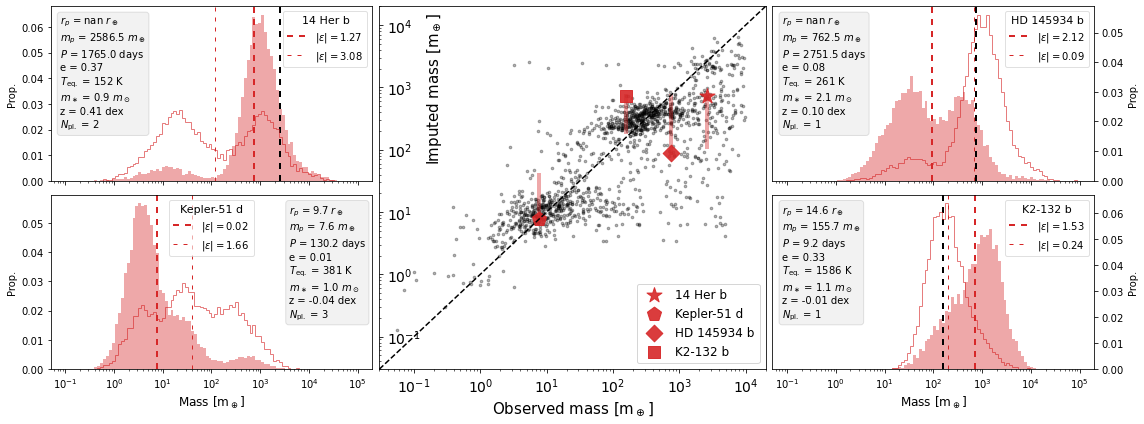

In [94]:
MJ = 317.8  # in Earth masses
MIN_MASS, MAX_MASS = 3e-2, 2e4  # 3e-1, 1.3e4

gs_kw = dict(width_ratios=[5, 6, 5])
fig, ax = plt.subplot_mosaic(
    [['hist_1a', 'main', 'hist_2a'],
     ['hist_1b', 'main', 'hist_2b']],
    gridspec_kw=gs_kw, figsize=(16, 6),
)

ax['main'].scatter(np_masses[2]*MJ, np_masses[1]*MJ, c='black', s=7, alpha=0.3)

idx1, idx2 = 0, 820  # Two improvements: 14 Her b ; Kepler-51 d
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
ax['main'].scatter(np_masses[2][idx1]*MJ, np_masses[1][idx1]*MJ, c='C3', marker='*', s=250, alpha=0.9, label=label1)
ax['main'].plot(2*[np_masses[2][idx1]*MJ], np_masses[[0,1]][:,idx1]*MJ, c='C3', lw=4, alpha=0.4)
ax['main'].scatter(np_masses[2][idx2]*MJ, np_masses[1][idx2]*MJ, c='C3', marker='p', s=220, alpha=0.9, label=label2)
ax['main'].plot(2*[np_masses[2][idx2]*MJ], np_masses[[0,1]][:,idx2]*MJ, c='C3', lw=4, alpha=0.4)
plot_hist_given_idx_and_ax(my_idx=idx1, my_ax=ax['hist_1a'], bio_xloc=0.03, legend_loc='upper right', hide_xtickslabels=True)
plot_hist_given_idx_and_ax(my_idx=idx2, my_ax=ax['hist_1b'], bio_xloc=0.74, legend_loc='upper center')
ax['hist_1b'].set_xlabel('Mass [m$_\oplus$]', size=12)

idx1, idx2 = 269, 429  # Two deteriorations: HD 145934 ; K2-132 b
label1 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx1]
label2 = list(DICT_OBSERVED_MASS_NAME_ID.keys())[idx2]
ax['main'].scatter(np_masses[2][idx1]*MJ, np_masses[1][idx1]*MJ, c='C3', marker='D', s=140, alpha=0.9, label=label1)
ax['main'].plot(2*[np_masses[2][idx1]*MJ], np_masses[[0,1]][:,idx1]*MJ, c='C3', lw=4, alpha=0.4)
ax['main'].scatter(np_masses[2][idx2]*MJ, np_masses[1][idx2]*MJ, c='C3', marker='s', s=140, alpha=0.9, label=label2)
ax['main'].plot(2*[np_masses[2][idx2]*MJ], np_masses[[0,1]][:,idx2]*MJ, c='C3', lw=4, alpha=0.4)
plot_hist_given_idx_and_ax(my_idx=idx1, my_ax=ax['hist_2a'], bio_xloc=0.03, legend_loc='upper right', hide_xtickslabels=True, yticksright=True)
plot_hist_given_idx_and_ax(my_idx=idx2, my_ax=ax['hist_2b'], bio_xloc=0.03, legend_loc='upper right', yticksright=True)
ax['hist_2b'].set_xlabel('Mass [m$_\oplus$]', size=12)

ax['main'].set_xscale('log')
ax['main'].set_yscale('log')
ax['main'].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax['main'].set_xlabel('Observed mass [m$_\oplus$]', size=15)
ax['main'].set_ylabel('Imputed mass [m$_\oplus$]  ', size=15, loc='top', labelpad=-65)
ax['main'].set_yticks([1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
ax['main'].set_yticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$', '$10^{3}$', '$10^{4}$'], horizontalalignment='left')
ax['main'].tick_params(axis='both', which='major', labelsize=14)
ax['main'].tick_params(axis='y', which='both', direction='in', pad=-8)
ax['main'].set_xlim(MIN_MASS, MAX_MASS)
ax['main'].set_ylim(MIN_MASS, MAX_MASS)
ax['main'].legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.08)
plt.savefig('additional_final_figures/whole_archive_transit_8params_chosen_distributions.pdf')
plt.show()

## Load previous results (RV scenario)

In [9]:
DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID = dict()  # name and row id for planets with observed mass AND radius
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]) and ~np.isnan(my_df['pl_radj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASS_AND_RADIUS = len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID)

In [10]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/rv_case_masses_radii.pkl', 'rb') as f:
    imputed_samples = pickle.load(f)  # Note: samples are in log

In [11]:
rad_distrib_numpy = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
mass_distrib_numpy = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
true_radii_numpy = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
true_masses_numpy = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))

for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    rad_distrib_numpy[i] = np.exp(imputed_samples[(cur_name, 'radius')])
    mass_distrib_numpy[i] = np.exp(imputed_samples[(cur_name, 'mass')])
    true_radii_numpy[i] = my_df.iloc[cur_idx]['pl_radj']
    true_masses_numpy[i] = my_df.iloc[cur_idx]['pl_bmassj']

rad_distrib_bis = np.zeros((3, 10000))  # for Kepler-406 b, Kepler-21 b, and K2-111 b
mass_distrib_bis = np.zeros((3, 10000))
true_masses_bis = np.zeros(3)
for n, save_name in enumerate(['Kepler-406 b', 'Kepler-21 b', 'K2-111 b']):
    idx = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID).index(save_name)
    true_masses_bis[n] = true_masses_numpy[idx]
    with open(f'results_and_figures/2_comp_whole_archive/_assessing_damage/rv_radius_{save_name}.pkl', 'rb') as f:
        temp = pickle.load(f)  # Note: here, samples are in Jupiter masses (so don't do anything here!)
        rad_distrib_bis[n, :] = temp
    with open(f'results_and_figures/2_comp_whole_archive/_assessing_damage/rv_mass_{save_name}.pkl', 'rb') as f:
        temp = pickle.load(f)  # Note: here, samples are in Jupiter masses (so don't do anything here!)
        mass_distrib_bis[n, :] = temp

In [12]:
np.random.seed(666)  # For reproducibility
nb_repeat = 100

rad_estimates = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
mass_estimates = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))

rad_estimates_bis = np.zeros((3, nb_repeat))
mass_estimates_bis = np.zeros((3, nb_repeat))

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    rad_estimates[:, n], mass_estimates[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_numpy,
        mass_distrib=mass_distrib_numpy,
        true_masses=true_masses_numpy,
        incl=cur_i,
    )
    rad_estimates_bis[:, n], mass_estimates_bis[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_bis,
        mass_distrib=mass_distrib_bis,
        true_masses=true_masses_bis,
        incl=cur_i,
    )

In [13]:
rad_imputed_values = np.mean(rad_estimates, axis=-1)
mass_imputed_values = np.mean(mass_estimates, axis=-1)

rad_eps = np.sqrt(np.mean((np.log(rad_imputed_values) - np.log(true_radii_numpy)) ** 2.0))
mass_eps = np.sqrt(np.mean((np.log(mass_imputed_values) - np.log(true_masses_numpy)) ** 2.0))

print(f'Radius ==> Epsilon = {rad_eps:.4f}')  # It's the same!
print(f'Mass ==> Epsilon = {mass_eps:.4f}')  # It's the same! GOOOD

Radius ==> Epsilon = 0.3980
Mass ==> Epsilon = 0.1806


### My ploting functions (RV scenario)

In [26]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses

my_rad_bins = np.geomspace(1e-1, 1e2, num=101)
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights = np.ones(rad_distrib_numpy.shape[1]) / rad_distrib_numpy.shape[1]

i = 567 ; Name = Kepler-406 b ; Common idx = 3741
i = 463 ; Name = Kepler-21 b ; Common idx = 3195
i = 279 ; Name = K2-111 b ; Common idx = 1280
i = 1079 ; Name = Uranus ; Common idx = 5249
i = 904 ; Name = WASP-110 b ; Common idx = 5009
i = 745 ; Name = TIC 172900988 b ; Common idx = 4755


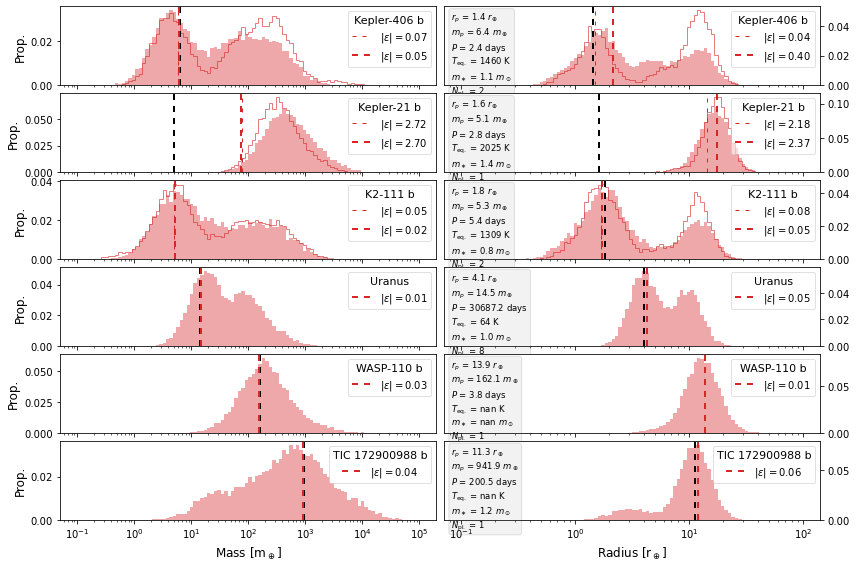

In [34]:
fig, ax = plt.subplots(6, 2, figsize=(12, 8))  # originally 3, 2, figsize=(12, 8)

for n1, n2 in enumerate([567, 463, 279, 1079, 904, 745]):
    
    for i, (cur_name, cur_idx) in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
        if i == n2:
            save_name = cur_name
            if save_name == 'uranus':
                save_name = 'Uranus'
            print(f'i = {i} ; Name = {save_name} ; Common idx = {cur_idx}')
            planet_bio = generate_planet_bio(cur_idx)
    
    true_rad = true_radii_numpy[n2] * RJ
    true_mass = true_masses_numpy[n2] * MJ
    imp_rad = rad_imputed_values[n2] * RJ
    imp_mass = mass_imputed_values[n2] * MJ
    eps_rad = np.log(imp_rad) - np.log(true_rad)
    eps_mass = np.log(imp_mass) - np.log(true_mass)
    
    if n1 in [0, 1, 2]:  # for Kepler-406 b, Kepler-21 b, and K2-111 b
        imp_mass_bis = np.mean(mass_estimates_bis[n1]) * MJ
        eps_mass_bis = np.log(imp_mass_bis) - np.log(true_mass)
        ax[n1][0].hist(mass_distrib_bis[n1]*MJ, bins=my_mass_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
        ax[n1][0].axvline(imp_mass_bis, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(eps_mass_bis):.2f}')
        imp_rad_bis = np.mean(rad_estimates_bis[n1]) * RJ
        eps_rad_bis = np.log(imp_rad_bis) - np.log(true_rad)
        ax[n1][1].hist(rad_distrib_bis[n1]*RJ, bins=my_rad_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
        ax[n1][1].axvline(imp_rad_bis, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(eps_rad_bis):.2f}')
    
    ax[n1][0].hist(mass_distrib_numpy[n2]*MJ, bins=my_mass_bins, weights=my_weights, color='C3', alpha=0.4)
    ax[n1][0].axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    ax[n1][0].axvline(imp_mass, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_mass):.2f}')
    ax[n1][1].hist(rad_distrib_numpy[n2]*RJ, bins=my_rad_bins, weights=my_weights, color='C3', alpha=0.4)
    ax[n1][1].axvline(true_rad, ls=(0, (3, 3)), c='black', lw=2)
    ax[n1][1].axvline(imp_rad, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_rad):.2f}')
    for n3 in range(2):
        ax[n1][n3].set_xscale('log')
        ax[n1][n3].legend(loc='upper right', fontsize=10, title=save_name, title_fontsize=11, framealpha=0.6)
    ax[n1][0].set_ylabel('Prop.', size=12)
    ax[n1][1].yaxis.tick_right()
    
    if n1 in [0, 1, 2, 3, 4]:
        ax[n1][0].xaxis.set_ticklabels([])
        ax[n1][1].xaxis.set_ticklabels([])

    props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
    ax[n1][1].text(0.02, 0.94, planet_bio, transform=ax[n1][1].transAxes, fontsize=8.5, verticalalignment='top', bbox=props)

ax[5][0].set_xlabel('Mass [m$_\oplus$]', size=12)
ax[5][1].set_xlabel('Radius [r$_\oplus$]', size=12)
    
fig.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.1)
plt.savefig('additional_final_figures/whole_archive_rv_chosen_distributions.pdf')
plt.show()

### With 8 parameters

In [109]:
DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID = dict()  # name and row id for planets with observed mass AND radius
for cur_idx in range(my_df.shape[0]):
    if ~np.isnan(my_df['pl_bmassj'].iloc[cur_idx]) and ~np.isnan(my_df['pl_radj'].iloc[cur_idx]):
        my_key = my_df['pl_name'].iloc[cur_idx]
        DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID[my_key] = cur_idx
NB_OBSERVED_MASS_AND_RADIUS = len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID)

In [110]:
save_dir = f'results_and_figures/2_comp_whole_archive'
with open(f'{save_dir}/rv_case_masses_radii.pkl', 'rb') as f:
    imputed_samples_6params = pickle.load(f)  # Note: samples are in log
with open(f'{save_dir}/rv_case_masses_radii_8params_nbn20_subset6.pkl', 'rb') as f:
    imputed_samples_8params = pickle.load(f)  # Note: samples are in log

In [111]:
rad_distrib_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
mass_distrib_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
rad_distrib_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
mass_distrib_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), 10000))
true_radii = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))
true_masses = np.zeros(len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID))

for i, (cur_name, cur_idx)  in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
    rad_distrib_6params[i] = np.exp(imputed_samples_6params[(cur_name, 'radius')])
    mass_distrib_6params[i] = np.exp(imputed_samples_6params[(cur_name, 'mass')])
    rad_distrib_8params[i] = np.exp(imputed_samples_8params[(cur_name, 'radius')])
    mass_distrib_8params[i] = np.exp(imputed_samples_8params[(cur_name, 'mass')])
    true_radii[i] = my_df.iloc[cur_idx]['pl_radj']
    true_masses[i] = my_df.iloc[cur_idx]['pl_bmassj']

In [112]:
np.random.seed(666)  # For reproducibility
nb_repeat = 100

rad_estimates_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
mass_estimates_6params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
rad_estimates_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))
mass_estimates_8params = np.zeros((len(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID), nb_repeat))

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    rad_estimates_6params[:, n], mass_estimates_6params[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib = rad_distrib_6params,
        mass_distrib = mass_distrib_6params,
        true_masses = true_masses,
        incl=cur_i,
    )
    rad_estimates_8params[:, n], mass_estimates_8params[:, n] = convolution_TLG2020_fix_incl(
        rad_distrib = rad_distrib_8params,
        mass_distrib = mass_distrib_8params,
        true_masses = true_masses,
        incl=cur_i,
    )

In [134]:
rad_imputed_values_6params = np.mean(rad_estimates_6params, axis=-1)
mass_imputed_values_6params = np.mean(mass_estimates_6params, axis=-1)
rad_imputed_values_8params = np.mean(rad_estimates_8params, axis=-1)
mass_imputed_values_8params = np.mean(mass_estimates_8params, axis=-1)

rad_eps_6params = np.sqrt(np.mean((np.log(rad_imputed_values_6params) - np.log(true_radii)) ** 2.0))
mass_eps_6params = np.sqrt(np.mean((np.log(mass_imputed_values_6params) - np.log(true_masses)) ** 2.0))

print('== 6 PARAMS ==')
print(f'Radius ==> Epsilon = {rad_eps_6params:.4f}')
print(f'Mass ==> Epsilon = {mass_eps_6params:.4f}')

rad_eps_8params = np.sqrt(np.mean((np.log(rad_imputed_values_8params) - np.log(true_radii)) ** 2.0))
mass_eps_8params = np.sqrt(np.mean((np.log(mass_imputed_values_8params) - np.log(true_masses)) ** 2.0))

print('== 8 PARAMS ==')
print(f'Radius ==> Epsilon = {rad_eps_8params:.4f}')
print(f'Mass ==> Epsilon = {mass_eps_8params:.4f}')

== 6 PARAMS ==
Radius ==> Epsilon = 0.3980
Mass ==> Epsilon = 0.1806
== 8 PARAMS ==
Radius ==> Epsilon = 0.3630
Mass ==> Epsilon = 0.1566


i = 683 ; Name = Kepler-98 b ; Common idx = 4520
i = 963 ; Name = WASP-18 b ; Common idx = 5072
i = 426 ; Name = Kepler-145 b ; Common idx = 2477


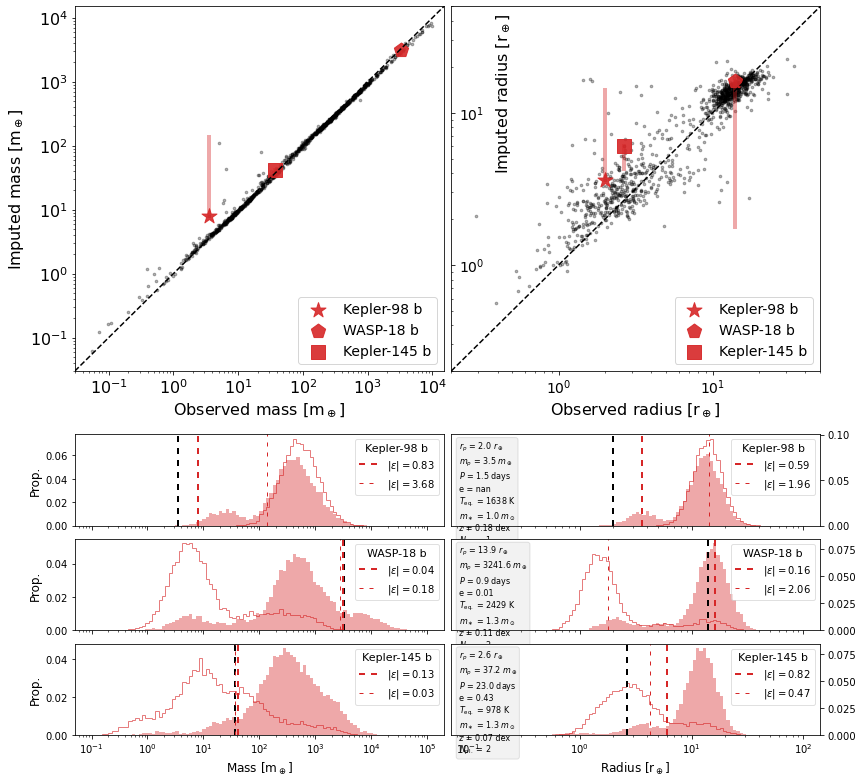

In [158]:
MIN_RAD, MAX_RAD = 2e-1, 5e1  # 4e-1, 5e1
MIN_MASS, MAX_MASS = 3e-2, 1.5e4  # 3e-1, 1.3e4

gs_kw = dict(height_ratios=[4, 0.4, 1, 1, 1])
fig, ax = plt.subplot_mosaic(
    [['main_mass', 'main_rad'],
     ['space', 'space'],
     ['hist_mass1', 'hist_rad1'],
     ['hist_mass2', 'hist_rad2'],
     ['hist_mass3', 'hist_rad3']],
    gridspec_kw=gs_kw, figsize=(12, 11),
)

ax['main_mass'].scatter(true_masses*MJ, mass_imputed_values_8params*MJ, c='black', s=7, alpha=0.3)
ax['main_rad'].scatter(true_radii*RJ, rad_imputed_values_8params*RJ, c='black', s=7, alpha=0.3)

idx1, idx2, idx3 = 683, 963, 426  # Kepler-98 b + WASP-18 b (2 improv.) ;  Kepler-145 b (degrad.)
for n, idx in enumerate([idx1, idx2, idx3]):
    label = list(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.keys())[idx]
    mark = ['*', 'p', 's'][n]
    size = [250, 225, 175][n]
    ax['main_mass'].scatter(true_masses[idx]*MJ, mass_imputed_values_8params[idx]*MJ, c='C3', marker=mark, s=size, alpha=0.9, label=label)
    ax['main_mass'].plot(2*[true_masses[idx]*MJ], [mass_imputed_values_6params[idx]*MJ,mass_imputed_values_8params[idx]*MJ], c='C3', lw=4, alpha=0.4)
    ax['main_rad'].scatter(true_radii[idx]*RJ, rad_imputed_values_8params[idx]*RJ, c='C3', marker=mark, s=size, alpha=0.9, label=label)
    ax['main_rad'].plot(2*[true_radii[idx]*RJ], [rad_imputed_values_6params[idx]*RJ,rad_imputed_values_8params[idx]*RJ], c='C3', lw=4, alpha=0.4)

for name in ['main_mass', 'main_rad']:
    ax[name].set_xscale('log')
    ax[name].set_yscale('log')
    ax[name].tick_params(axis='both', which='major', labelsize=16)
    ax[name].legend(fontsize=14, loc='lower right')
ax['main_mass'].set_xlabel('Observed mass [m$_\oplus$]', size=16)
ax['main_mass'].set_ylabel('Imputed mass [m$_\oplus$]', size=16)
ax['main_mass'].plot([MIN_MASS, MAX_MASS], [MIN_MASS, MAX_MASS], 'k--')
ax['main_mass'].set_xlim(MIN_MASS, MAX_MASS)
ax['main_mass'].set_ylim(MIN_MASS, MAX_MASS)
ax['main_rad'].set_xlabel('Observed radius [r$_\oplus$]', size=16)
ax['main_rad'].set_ylabel('Imputed radius [r$_\oplus$]  ', size=16, loc='top', labelpad=-62)
ax['main_rad'].plot([MIN_RAD, MAX_RAD], [MIN_RAD, MAX_RAD], 'k--')
ax['main_rad'].set_xlim(MIN_RAD, MAX_RAD)
ax['main_rad'].set_ylim(MIN_RAD, MAX_RAD)
ax['main_rad'].set_yticks([1e0, 1e1])
ax['main_rad'].set_yticklabels(['$10^{0}$', '$10^{1}$'], horizontalalignment='left')
ax['main_rad'].tick_params(axis='both', which='major', labelsize=14)
ax['main_rad'].tick_params(axis='y', which='both', direction='in', pad=-8)


for n, idx in enumerate([idx1, idx2, idx3]):
    true_mass = true_masses[idx] * MJ
    true_rad = true_radii[idx] * RJ
    imp_mass_8params = mass_imputed_values_8params[idx] * MJ
    imp_rad_8params = rad_imputed_values_8params[idx] * RJ
    imp_mass_6params = mass_imputed_values_6params[idx] * MJ
    imp_rad_6params = rad_imputed_values_6params[idx] * RJ
    eps_mass_8params = np.log(imp_mass_8params) - np.log(true_mass)
    eps_rad_8params = np.log(imp_rad_8params) - np.log(true_rad)
    eps_mass_6params = np.log(imp_mass_6params) - np.log(true_mass)
    eps_rad_6params = np.log(imp_rad_6params) - np.log(true_rad)

    ax[f'hist_mass{n+1}'].hist(mass_distrib_8params[idx]*MJ, bins=my_mass_bins, weights=my_weights, color='C3', alpha=0.4)
    ax[f'hist_mass{n+1}'].hist(mass_distrib_6params[idx]*MJ, bins=my_mass_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
    ax[f'hist_mass{n+1}'].axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    ax[f'hist_mass{n+1}'].axvline(imp_mass_8params, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_mass_8params):.2f}')
    ax[f'hist_mass{n+1}'].axvline(imp_mass_6params, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(eps_mass_6params):.2f}')
    ax[f'hist_rad{n+1}'].hist(rad_distrib_8params[idx]*RJ, bins=my_rad_bins, weights=my_weights, color='C3', alpha=0.4)
    ax[f'hist_rad{n+1}'].hist(rad_distrib_6params[idx]*RJ, bins=my_rad_bins, weights=my_weights, histtype='step', color='C3', alpha=0.6)
    ax[f'hist_rad{n+1}'].axvline(true_rad, ls=(0, (3, 3)), c='black', lw=2)
    ax[f'hist_rad{n+1}'].axvline(imp_rad_8params, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_rad_8params):.2f}')
    ax[f'hist_rad{n+1}'].axvline(imp_rad_6params, ls=(0, (4, 6)), c='C3', lw=1, label=f'$|\\varepsilon|=${np.abs(eps_rad_6params):.2f}')
    
    for i, (cur_name, cur_idx) in enumerate(DICT_OBSERVED_MASS_AND_RADIUS_NAME_ID.items()):
        if i == idx:
            save_name = cur_name
            if save_name == 'uranus':
                save_name = 'Uranus'
            print(f'i = {i} ; Name = {save_name} ; Common idx = {cur_idx}')
            planet_bio = generate_planet_bio(cur_idx)
    
    ax[f'hist_mass{n+1}'].set_xscale('log')
    ax[f'hist_rad{n+1}'].set_xscale('log')
    ax[f'hist_mass{n+1}'].legend(loc='upper right', fontsize=10, title=save_name, title_fontsize=11, framealpha=0.6)
    ax[f'hist_rad{n+1}'].legend(loc='upper right', fontsize=10, title=save_name, title_fontsize=11, framealpha=0.6)
    ax[f'hist_mass{n+1}'].set_ylabel('Prop.', size=12)
    ax[f'hist_rad{n+1}'].yaxis.tick_right()

    props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
    ax[f'hist_rad{n+1}'].text(0.02, 0.94, planet_bio, transform=ax[f'hist_rad{n+1}'].transAxes, fontsize=8, verticalalignment='top', bbox=props)

ax['hist_mass1'].xaxis.set_ticklabels([])
ax['hist_rad1'].xaxis.set_ticklabels([])
ax['hist_mass2'].xaxis.set_ticklabels([])
ax['hist_rad2'].xaxis.set_ticklabels([])
ax['hist_mass3'].set_xlabel('Mass [m$_\oplus$]', size=12)
ax['hist_rad3'].set_xlabel('Radius [r$_\oplus$]', size=12)
    
fig.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.1)
ax['space'].set_visible(False)
plt.savefig('additional_final_figures/whole_archive_rv_8params_chosen_distributions.pdf')
plt.show()